In [1]:
import os, sys
import io
import requests
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import cv2
import torch
import piq
import nvidia_smi

# local library of functions to connect to image server
import libutils.use_server as server

# Notebook to explore ideas for image metrics

In [2]:
img_path = server.init() 

server : http://imgserver.10.68.0.250.nip.io/data/andra


In [3]:
files = server.get_list(img_path)
print("nombre de fichiers disponibles", len(files))
dirnames = []
for i in range(len(files)):
    dirnames.append(files[i].split('/')[4])
    
listdir = set(dirnames)
realdir = []
photo_not_in_dir = []
for ldir in listdir:
    if '.jpg' in ldir:
        photo_not_in_dir.append(ldir)
    else:
        realdir.append(ldir)

Status Code 200
nombre de fichiers disponibles 2268


In [4]:
files[0]

'/data/andra/calci_photos/REP2104/Photos/GTR2004-12_0017_REP2104_0065_0161.jpg'

In [5]:
sortedlist = sorted(realdir)

### The variance of the Laplacian can be a measure of the sharpness of the image, or the focus

In [6]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

### Function to read a directory and return some metrics

Bundle the metric calculation into one function. Add some Facebook metrics too: `piq` PyTorch Image Quality
* https://github.com/photosynthesis-team/piq/blob/master/examples/image_metrics.py

In [7]:
def read_directory(dirname, allfiles, quiet=True):
    """
    Function to read all images in a directory and return a data frame with image metrics
    
    parameters
    ----------
    dirname
        Name of directory to be read
    allfiles
        List of all files in the image server
        
    returns
    -------
    df
        Pandas dataframe of image metrics
    
    """
    ImageId = []
    Path = []
    FileName = []
    DrillName = []
    Cote0 = []
    Cote1 = []
    PxSize = []
    PySize = []
    Focus = []
    BRISQUE_i = []
    BRISQUE_l = []

    for file in allfiles:
        if dirname in file:
            img = server.get_file(file, quiet)
            #if img.size() > 89478485:
            #    continue
            l0 = file.split('/')[-1]
            l1 = l0.split('.')[0]
            l2 = l1.split('_')
            if len(l2)<3:
                continue
            width, height = img.size
            if width*height > 89478485:
                print(f'Not enough memory to process image {file} with PyTorch on local ')
            ImageId.append(0)
            Path.append(file)
            FileName.append(l0)
            DrillName.append(l2[-3])
            Cote0.append(l2[-2])
            Cote1.append(l2[-1])
            PxSize.append(width)
            PySize.append(height)

            # focus metric
            gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
            Focus.append(variance_of_laplacian(gray))
            
            # pytorch image quality, use try, except loop to kep going if image is too large or does not conform
            try:
                x = torch.tensor(np.asarray(img)).permute(2, 0, 1)[None, ...] / 255.
                if torch.cuda.is_available():
                    # Move to GPU to make computaions faster
                    # print(torch.cuda.is_available())
                    x = x.cuda()
                brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')
                brisque_loss: torch.Tensor = piq.BRISQUELoss(data_range=1., reduction='none')(x)

                BRISQUE_i.append(brisque_index.item())
                BRISQUE_l.append(brisque_loss.item())
            except:
                print(f'Error in PyTorch with image {file}')
                BRISQUE_i.append(np.nan)
                BRISQUE_l.append(np.nan)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            del x


    d = {'ImageId':ImageId, 'Path':Path, 'FileName':FileName, 'DrillName':DrillName,
         'Cote0':Cote0, 'Cote1':Cote1, 'PxSize':PxSize, 'PySize':PySize, 'Focus':Focus,
         'BRISQUE index':BRISQUE_i, 'BRISQUE loss':BRISQUE_l}
    df = pd.DataFrame(data=d)
    
    return df

In [8]:
df = read_directory(sortedlist[3], files)
df.sort_values('Cote0')

,ImageId,Path,FileName,DrillName,Cote0,Cote1,PxSize,PySize,Focus,BRISQUE index,BRISQUE loss
3,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0000_0104.jpg,DCN2002,0000,0104,2988,621,37.517755,26.670593,26.670593
1,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0078_0193.jpg,DCN2002,0078,0193,3456,633,138.378121,29.238464,29.238464
2,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0168_0288.jpg,DCN2002,0168,0288,3456,611,98.348385,25.632019,25.632019
0,0,/data/andra/calci_photos/DCN2002/Photos/GTR201...,GTR2014-10_0026_DCN2002_0260_0353.jpg,DCN2002,0260,0353,3234,624,54.526664,29.191589,29.191589


Status Code 200


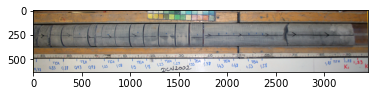

In [9]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


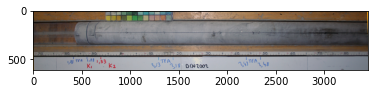

In [10]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmin()])
plt.imshow(img)
plt.show()

## Find the worst and best image by Focus and BRISQUE

In [21]:
del df
if os.path.isfile('./BRISQUE_data.pkl') == False:
    for i, directory in enumerate(sortedlist):

        print(f'Going into {directory}, i={i}')
        if i == 0:
            df = read_directory(directory, files)
        else:
            _df = read_directory(directory, files)
            df = pd.concat([df, _df])


        nvidia_smi.nvmlInit()
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
        # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate
        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        print("Free memory:", info.free)
        nvidia_smi.nvmlShutdown()

    df.to_pickle('./BRISQUE_data.pkl')
else:
    df = pd.read_pickle('./BRISQUE_data.pkl')
df = df.reset_index(drop=True)

In [22]:
df

,ImageId,Path,FileName,DrillName,Cote0,Cote1,PxSize,PySize,Focus,BRISQUE index,BRISQUE loss
0,0.0,/data/andra/calci_photos/BPE4023/Photos/GTR201...,GTR2012-07_0023_BPE4023_0600_0660.jpg,BPE4023,0600,0660,2231.0,631.0,259.652552,6.322937,6.322937
1,0.0,/data/andra/calci_photos/BPE4023/Photos/GTR201...,GTR2012-07_0023_BPE4023_0090_0200.jpg,BPE4023,0090,0200,3456.0,630.0,173.466555,10.439636,10.439636
2,0.0,/data/andra/calci_photos/BPE4023/Photos/GTR201...,GTR2012-07_0023_BPE4023_0510_0600.jpg,BPE4023,0510,0600,3456.0,642.0,128.287254,17.947449,17.947449
3,0.0,/data/andra/calci_photos/BPE4023/Photos/GTR201...,GTR2012-07_0023_BPE4023_0000_0110.jpg,BPE4023,0000,0110,3231.0,625.0,198.832689,15.736023,15.736023
4,0.0,/data/andra/calci_photos/BPE4023/Photos/GTR201...,GTR2012-07_0023_BPE4023_0440_0530.jpg,BPE4023,0440,0530,3088.0,622.0,199.275918,6.251160,6.251160
...,...,...,...,...,...,...,...,...,...,...,...
1964,0.0,/data/andra/calci_photos/TPV1322/Photos/GTR201...,GTR2012-12_0034_TPV1322_6083_6115.jpg,TPV1322,6083,6115,1628.0,664.0,173.632713,7.528503,7.528503
1965,0.0,/data/andra/calci_photos/TPV1322/Photos/GTR201...,GTR2012-12_0034_TPV1322_5373_5486.jpg,TPV1322,5373,5486,3456.0,700.0,172.987680,15.328308,15.328308
1966,0.0,/data/andra/calci_photos/TPV1322/Photos/GTR201...,GTR2012-12_0034_TPV1322_3160_3280.jpg,TPV1322,3160,3280,3456.0,624.0,143.665496,18.815613,18.815613
1967,0.0,/data/andra/calci_photos/TPV1322/Photos/GTR201...,GTR2012-12_0034_TPV1322_1300_1418.jpg,TPV1322,1300,1418,3456.0,633.0,190.285586,5.972839,5.972839


<Figure size 720x720 with 0 Axes>

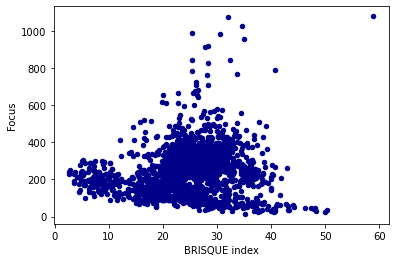

In [30]:
plt.figure(figsize=[10,10])
ax = df.plot.scatter(x='BRISQUE index', y='Focus', c='DarkBlue')
plt.show()

Status Code 200


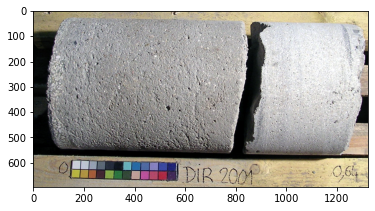

In [25]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


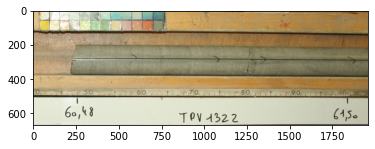

In [26]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmin()])
plt.imshow(img)
plt.show()

Status Code 200


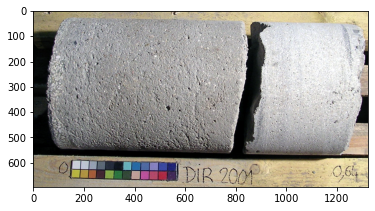

In [27]:
img = server.get_file(df['Path'][df['Focus'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


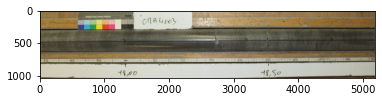

In [28]:
img = server.get_file(df['Path'][df['Focus'].idxmin()])
plt.imshow(img)
plt.show()